# Automatic number plate recognition (ANPR) with Yolov9 and EasyOCR

data: https://universe.roboflow.com/arvind-kumar-wjygd/anpr2-syxl7

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Feb 16 10:27:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 2.25 MiB | 41.08 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.2 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.8 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Feb 16 10:29 .
drwxr-xr-x 1 root root      4096 Feb 16 10:29 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [7]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [9]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("arvind-kumar-wjygd").project("anpr2-syxl7")
version = project.version(8)
dataset = version.download("yolov9")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ANPR2-8 in yolov9:: 100%|██████████| 626/626 [00:00<00:00, 7997.33it/s]


## Train Custom Model

In [10]:
dataset.location

'/content/yolov9/ANPR2-8'

In [12]:
HOME

'/content'

In [13]:
# Check the actual dataset structure
import os
print("Dataset location:", dataset.location)
print("\nDataset contents:")
os.listdir(dataset.location)

# The data.yaml file needs to be updated with correct paths
import yaml

# Read the current data.yaml
data_yaml_path = f"{dataset.location}/data.yaml"
with open(data_yaml_path, 'r') as f:
    data = yaml.safe_load(f)

print("\nOriginal data.yaml:")
print(data)

# Update paths to be absolute
data['train'] = f"{dataset.location}/train/images"
data['val'] = f"{dataset.location}/valid/images"  # or 'test' depending on your dataset

# Some datasets use 'valid', others use 'val' - check which exists
if not os.path.exists(f"{dataset.location}/valid"):
    if os.path.exists(f"{dataset.location}/test"):
        data['val'] = f"{dataset.location}/test/images"
    elif os.path.exists(f"{dataset.location}/val"):
        data['val'] = f"{dataset.location}/val/images"

# Write back the corrected data.yaml
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print("\nUpdated data.yaml:")
print(data)

# Verify paths exist
print("\nVerifying paths:")
print(f"Train exists: {os.path.exists(data['train'])}")
print(f"Val exists: {os.path.exists(data['val'])}")

Dataset location: /content/yolov9/ANPR2-8

Dataset contents:

Original data.yaml:
{'names': ['licence'], 'nc': 1, 'roboflow': {'license': 'CC BY 4.0', 'project': 'anpr2-syxl7', 'url': 'https://universe.roboflow.com/arvind-kumar-wjygd/anpr2-syxl7/dataset/8', 'version': 8, 'workspace': 'arvind-kumar-wjygd'}, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}

Updated data.yaml:
{'names': ['licence'], 'nc': 1, 'roboflow': {'license': 'CC BY 4.0', 'project': 'anpr2-syxl7', 'url': 'https://universe.roboflow.com/arvind-kumar-wjygd/anpr2-syxl7/dataset/8', 'version': 8, 'workspace': 'arvind-kumar-wjygd'}, 'test': '../test/images', 'train': '/content/yolov9/ANPR2-8/train/images', 'val': '/content/yolov9/ANPR2-8/valid/images'}

Verifying paths:
Train exists: True
Val exists: True


In [15]:
!sed -i "s/torch.load(weights, map_location='cpu')/torch.load(weights, map_location='cpu', weights_only=False)/g" /content/yolov9/train.py
print("✓ Fixed torch.load() in train.py")

✓ Fixed torch.load() in train.py


In [19]:
# Fix the Pillow getsize() deprecation issue
!sed -i 's/w, h = self.font.getsize(label)/w, h = self.font.getbbox(label)[2:4]/g' /content/yolov9/utils/plots.py
print("✓ Fixed Pillow getsize() deprecation in plots.py")

✓ Fixed Pillow getsize() deprecation in plots.py


In [21]:
# Fix the torch.load issue in utils/general.py for strip_optimizer function
!sed -i "s/x = torch.load(f, map_location=torch.device('cpu'))/x = torch.load(f, map_location=torch.device('cpu'), weights_only=False)/g" /content/yolov9/utils/general.py

print("✓ Fixed torch.load() in utils/general.py")

✓ Fixed torch.load() in utils/general.py


In [20]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 300 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2026-02-16 10:50:33.445003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771239033.466280    6406 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771239033.473334    6406 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771239033.492010    6406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771239033.492039    6406 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771239033.492043    6406 computation_placer.cc:177] comput

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [23]:
!ls {HOME}/yolov9/runs/train/exp5/

events.out.tfevents.1771239039.341553bfc75c.6406.0  results.csv
hyp.yaml					    train_batch0.jpg
labels_correlogram.jpg				    train_batch1.jpg
labels.jpg					    train_batch2.jpg
opt.yaml					    weights


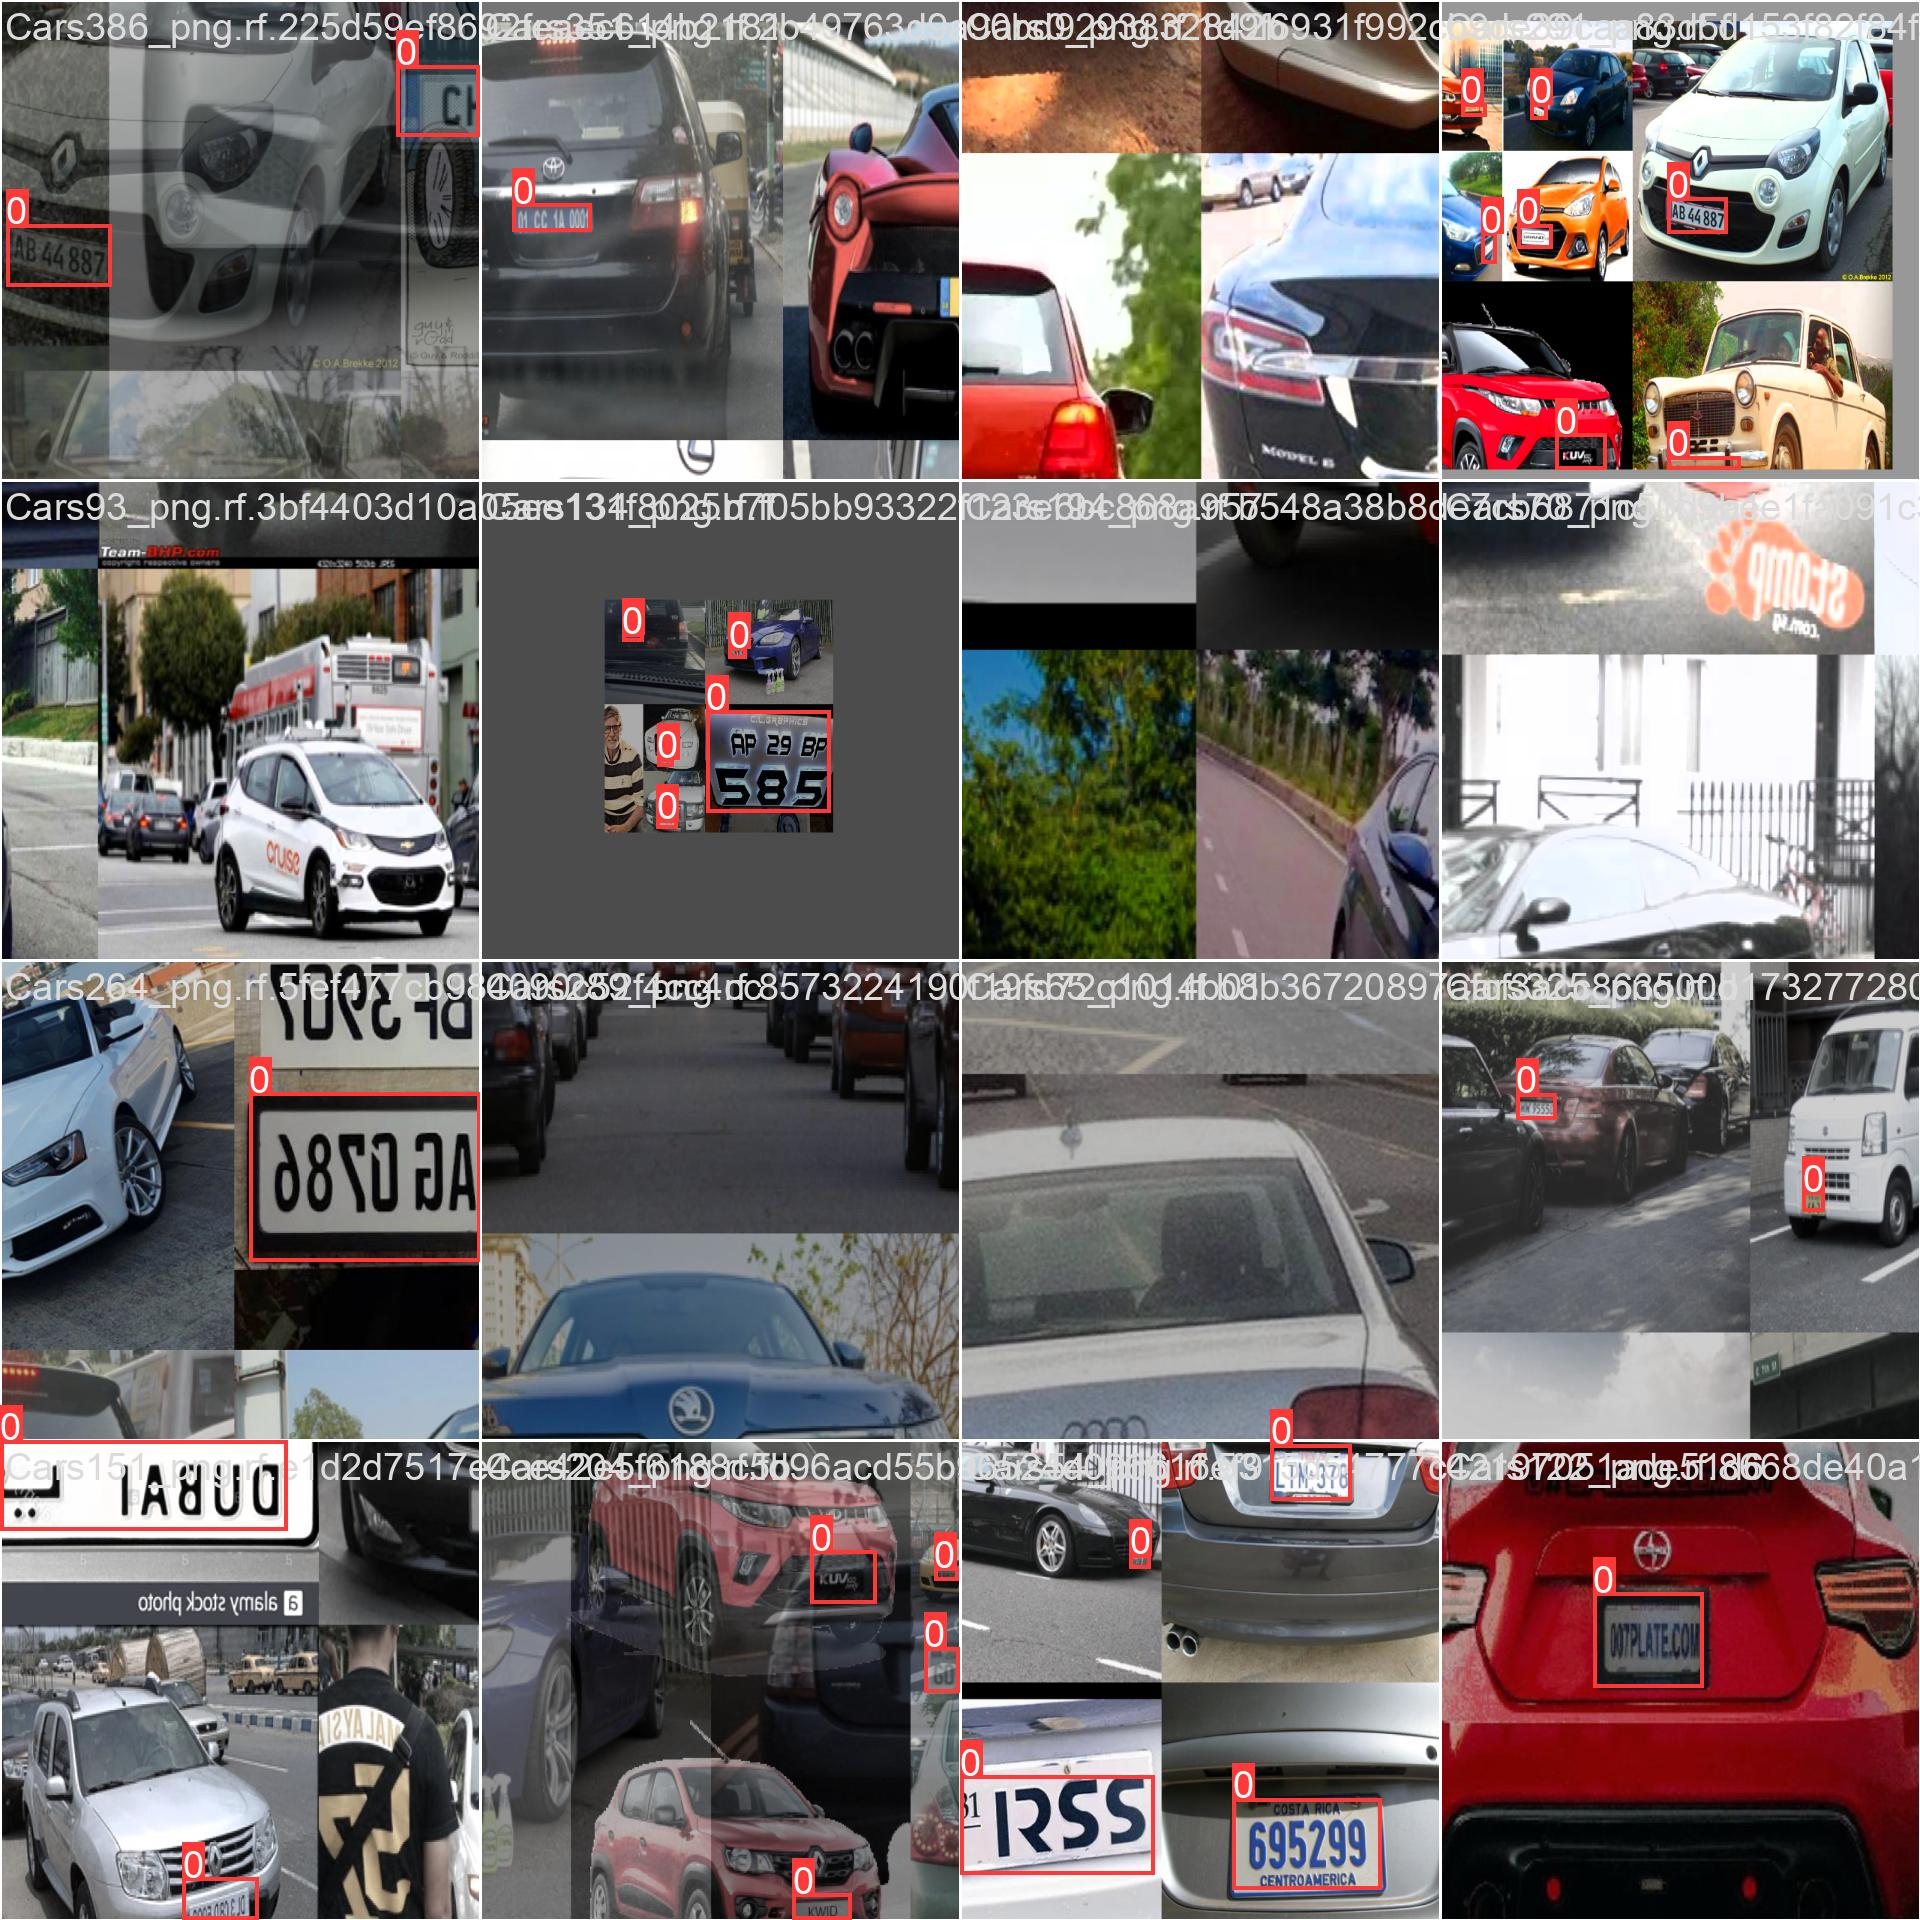

In [26]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp5/train_batch0.jpg", width=1000)

## Validate Custom Model

In [28]:
# Fix torch.load in models/experimental.py (used by val.py)
!sed -i "s/ckpt = torch.load(attempt_download(w), map_location='cpu')/ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)/g" /content/yolov9/models/experimental.py

print("✓ Fixed torch.load() in models/experimental.py")

✓ Fixed torch.load() in models/experimental.py


In [29]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp5/weights/best.pt

/content/yolov9
val: data=/content/yolov9/ANPR2-8/data.yaml, weights=['/content/yolov9/runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/ANPR2-8/valid/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100% 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.74it/s]
                   all          6         20      0.941      0.798      0.926      0.683
Speed: 1.3ms pre-process, 47.0ms inference, 11.6ms NMS per image at sha

## Inference with Custom Model

In [31]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp5/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp5/weights/best.pt'], source=/content/yolov9/ANPR2-8/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
image 1/23 /content/yolov9/ANPR2-8/test/images/Cars411_png.rf.667117ea55d973fada6f86e842cf8000.jpg: 1280x1280 4 licences, 106.2ms
image 2/23 /content/yolov9/ANPR2-8/test/images/Cars412_png.rf.23df9b6cd177dad7b799613dcfa3ee18.jpg: 1280x1280 2 licences, 104.6ms
image 3/23 /content/yolov9/ANPR2-8/test/images/Cars413_pn

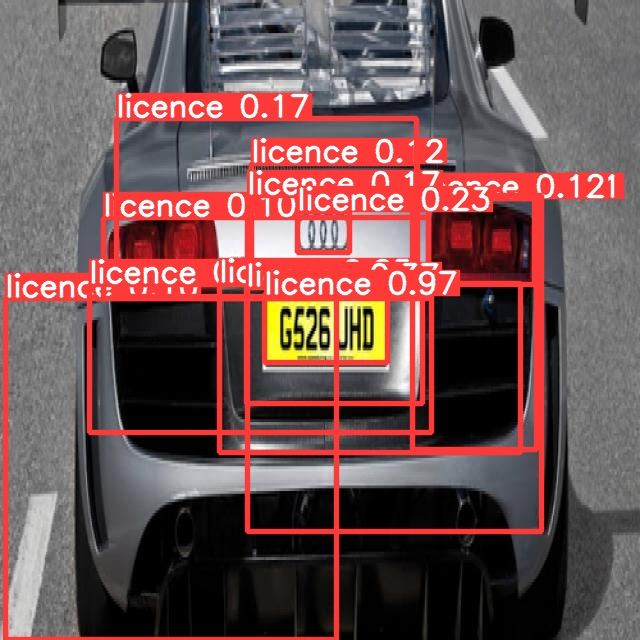

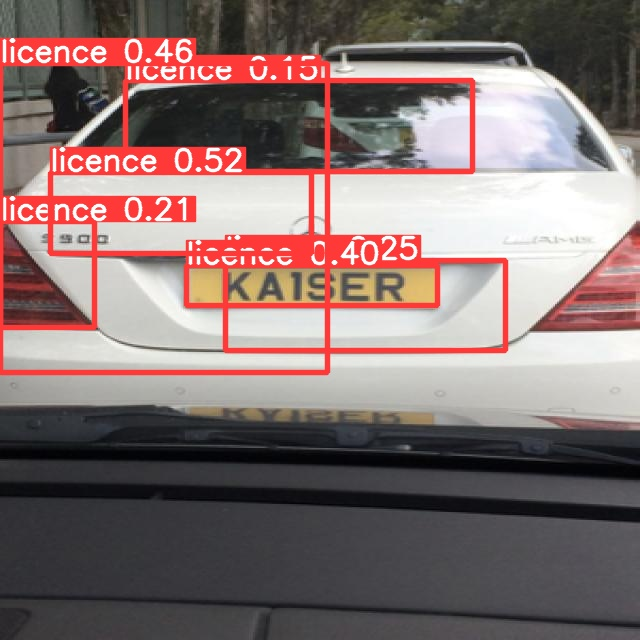

In [32]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp2/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))